In [1]:
from util import *

# Basic Source Correlation & Strategy Notebook

Extended version of the basic correlation notebook. Looking at training models on all sources to forecast moves.

In [2]:
# Change to directory of dataset file
# Dataset file is guaranteed to have all days for all stocks, i.e. shift(30) is guaranteed to be 30 calendar days
# This leaves a lot of NaNs to be filled
path = "~/s3local/sentimentgroup/datasets/roberta_sources.parquet"

In [3]:
# Horizons to calculate future returns (e.g. price after N days)
target_horizons = [1, 3, 5, 10, 30]
# Horizons to calculate lookbacks for rolling means (e.g. mean sentiment over last N days)
lookback_periods = [5, 10, 40]
# Enable to add residualised returns as a target 
# Also known as idiosyncratic returns, ie individual stock returns after removing overall market trends 
# Takes about 60 seconds per target horizon, so disable if not needed
residualise_returns = False

# Date range, leave None to use all available data (where we have prices)
start_date = "2014-01-01"
end_date = "2022-01-01" # Keep out of sample for now
df = load_dataset(
    path,
    target_horizons = target_horizons,
    lookback_periods = lookback_periods,
    residualise_returns = residualise_returns,
    start_date=start_date,
    end_date=end_date,
    sources=True,
)

100%|██████████| 5/5 [00:02<00:00,  2.09it/s]
/Users/raleghaustin/Documents/uni/group-project/Correlation/util.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_{lookback}"] = np.array(((
/Users/raleghaustin/Documents/uni/group-project/Correlation/util.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_{lookback}"] = np.array(((
/Users/raleghaustin/Documents/uni/group-project/Correlation/util.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

*Analysing correlations between signals and target returns.*


In [5]:
list(df.columns)

['dt',
 'symbol',
 'ft_comments_technology',
 'ft_comments_worldnews',
 'ft_comments_news',
 'ft_comments_finance',
 'ft_comments_Bitcoin',
 'ft_comments_investing',
 'ft_comments_financialindependence',
 'ft_comments_StockMarket',
 'ft_comments_wallstreetbets',
 'ft_comments_UpliftingNews',
 'ft_comments_CryptoCurrency',
 'ft_comments_Daytrading',
 'ft_comments_Superstonk',
 'ft_submissions_politics',
 'ft_submissions_technology',
 'ft_submissions_worldnews',
 'ft_submissions_news',
 'ft_submissions_finance',
 'ft_submissions_investing',
 'ft_submissions_Bitcoin',
 'ft_submissions_financialindependence',
 'ft_submissions_StockMarket',
 'ft_submissions_wallstreetbets',
 'ft_submissions_UpliftingNews',
 'ft_submissions_CryptoCurrency',
 'ft_submissions_Daytrading',
 'ft_submissions_Superstonk',
 'ft_news_vulture',
 'ft_news_the_mercury_news',
 'ft_news_the_hill',
 'ft_news_the_associated_press',
 'ft_news_nbc10_boston',
 'ft_news_quartz_india',
 'ft_news_gamesradar',
 'ft_news_forbes',


In [4]:
df["ft_past_returns_30"] = df.groupby("symbol")["close"].pct_change(30).reset_index(0, drop=True)
df["ft_past_returns_5"] = df.groupby("symbol")["close"].pct_change(5).reset_index(0, drop=True)
df['ft_close'] = df.close

In [13]:
# news_fts = [c for c in df.columns if c.startswith('ft_news') and (c.endswith('_30') or c.endswith('_10'))]
# submissions_fts = [c for c in df.columns if c.startswith('ft_submissions') and (c.endswith('_30') or c.endswith('_10'))]
# comments_fts = [c for c in df.columns if c.startswith('ft_comments') and (c.endswith('_30') or c.endswith('_10'))]

news_fts = [c for c in df.columns if c.startswith('ft_news') and (c[-1].isdigit())]
submissions_fts = [c for c in df.columns if c.startswith('ft_submissions') and (c[-1].isdigit())]
comments_fts = [c for c in df.columns if c.startswith('ft_comments') and (c[-1].isdigit())]

In [32]:
corrs = []
for c in comments_fts:
    if c.endswith('10'):
        corrs.append((c.split('_')[2], pearsonr(df[c], df['tgt_forward_returns_10'])[0]))
corrs = sorted(corrs, key=lambda x: x[1])

TypeError: unhashable type: 'numpy.ndarray'

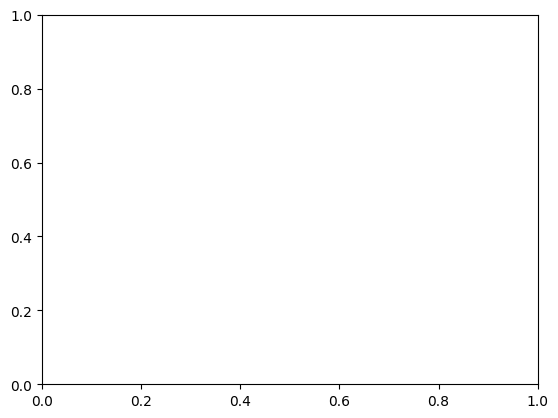

In [33]:
df = 

In [28]:
pearsonr(df[c], df['tgt_forward_returns_10'])[0]

-0.0023116179579193786

In [25]:
for k, p in corrs:
    print(k, p)

CryptoCurrency PearsonRResult(statistic=-0.0034229853089575543, pvalue=0.00011290641502851959)
Superstonk PearsonRResult(statistic=-0.0018688257619856648, pvalue=0.03503252809939123)
finance PearsonRResult(statistic=-0.0013445673976067985, pvalue=0.1293593496958695)
Daytrading PearsonRResult(statistic=-0.00039989299342100686, pvalue=0.6519408811678524)
technology PearsonRResult(statistic=-0.00017778329763176249, pvalue=0.84106271902979)
worldnews PearsonRResult(statistic=0.0003445624535654373, pvalue=0.697530411442215)
Bitcoin PearsonRResult(statistic=0.0007314426630114724, pvalue=0.4093455474258885)
news PearsonRResult(statistic=0.001607885759611758, pvalue=0.06973179490188025)
investing PearsonRResult(statistic=0.0021466925842852963, pvalue=0.015460482205643588)
StockMarket PearsonRResult(statistic=0.0024119256260032407, pvalue=0.006516652242876455)
financialindependence PearsonRResult(statistic=0.0028510524982146433, pvalue=0.0013003173514651602)
UpliftingNews PearsonRResult(statist

In [140]:
from catboost import CatBoostRegressor

In [115]:
from sklearn.linear_model import Ridge

In [354]:
m = Ridge()
m.fit(train[news_fts+submissions_fts+comments_fts], train['tgt_forward_returns_30'] )
val['pred'] = m.predict(val[news_fts+submissions_fts+comments_fts])

In [363]:
pearsonr(val.pred, val.tgt_forward_returns_30)

PearsonRResult(statistic=0.007288804083019612, pvalue=1.1397293811095618e-07)

In [186]:
m = CatBoostRegressor(n_estimators=300, learning_rate=0.1, max_depth=3)
m.fit(train[comments_fts + news_fts + submissions_fts], train['tgt_forward_returns_10'])
val['pred'] = m.predict(val[comments_fts + news_fts + submissions_fts])

0:	learn: 0.0431296	total: 67.9ms	remaining: 20.3s
1:	learn: 0.0431277	total: 129ms	remaining: 19.3s
2:	learn: 0.0431262	total: 189ms	remaining: 18.7s
3:	learn: 0.0431239	total: 250ms	remaining: 18.5s
4:	learn: 0.0431219	total: 311ms	remaining: 18.4s
5:	learn: 0.0431205	total: 372ms	remaining: 18.2s
6:	learn: 0.0431127	total: 435ms	remaining: 18.2s
7:	learn: 0.0431112	total: 496ms	remaining: 18.1s
8:	learn: 0.0431099	total: 597ms	remaining: 19.3s
9:	learn: 0.0431081	total: 665ms	remaining: 19.3s
10:	learn: 0.0431062	total: 735ms	remaining: 19.3s
11:	learn: 0.0431043	total: 797ms	remaining: 19.1s
12:	learn: 0.0431029	total: 858ms	remaining: 18.9s
13:	learn: 0.0431019	total: 919ms	remaining: 18.8s
14:	learn: 0.0431005	total: 981ms	remaining: 18.6s
15:	learn: 0.0430982	total: 1.04s	remaining: 18.5s
16:	learn: 0.0430973	total: 1.11s	remaining: 18.5s
17:	learn: 0.0430924	total: 1.18s	remaining: 18.5s
18:	learn: 0.0430905	total: 1.24s	remaining: 18.3s
19:	learn: 0.0430858	total: 1.3s	remaini

<Axes: >

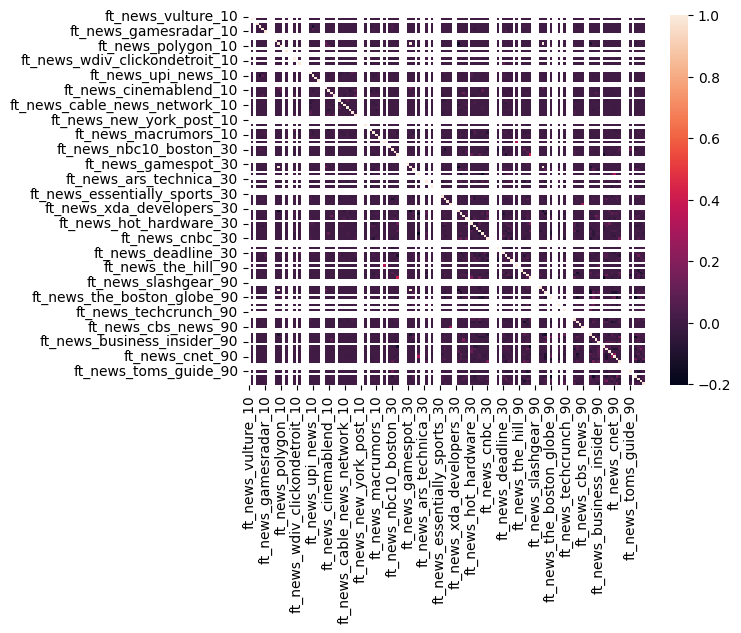

In [16]:
sns.heatmap(train[news_fts].corr())

In [187]:
pearsonr(val.pred, val.tgt_forward_returns_10)

PearsonRResult(statistic=0.0018973720125111193, pvalue=0.26308688452891305)

<Axes: xlabel='date'>

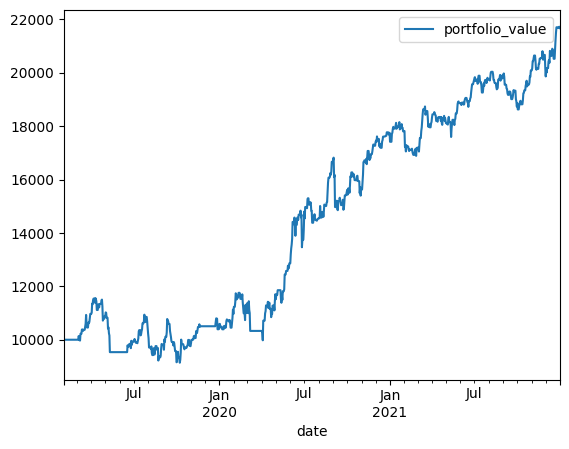

In [362]:
val['signal'] = 1.0
val['signal'] = (val.pred > 0.1).astype(float)
port, pos = simulate_portfolio_vectorized(val, tc_rate=0.000)
port.reset_index().plot(x='date', y='portfolio_value')

In [ ]:
df['signal'] = df.ft_abs_submissions_90

In [60]:

df['signal'] = df['ft_comments_30'].fillna(0).clip(0)
# df['signal'] = df['ft_pred'] * 3
port2, pos2 = simulate_portfolio_vectorized(df, tc_rate=0)

<Axes: xlabel='date'>

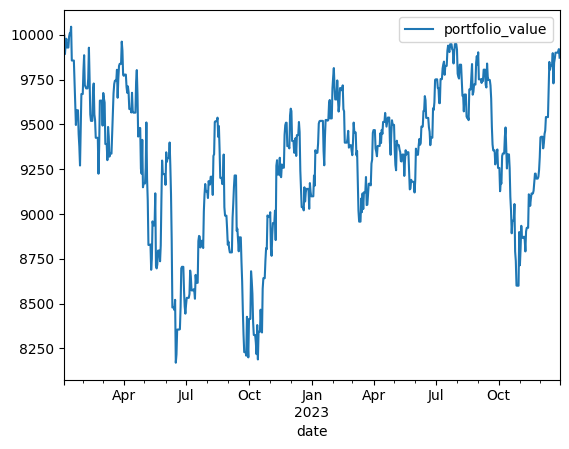

In [61]:
port2.reset_index().plot(x='date', y='portfolio_value')


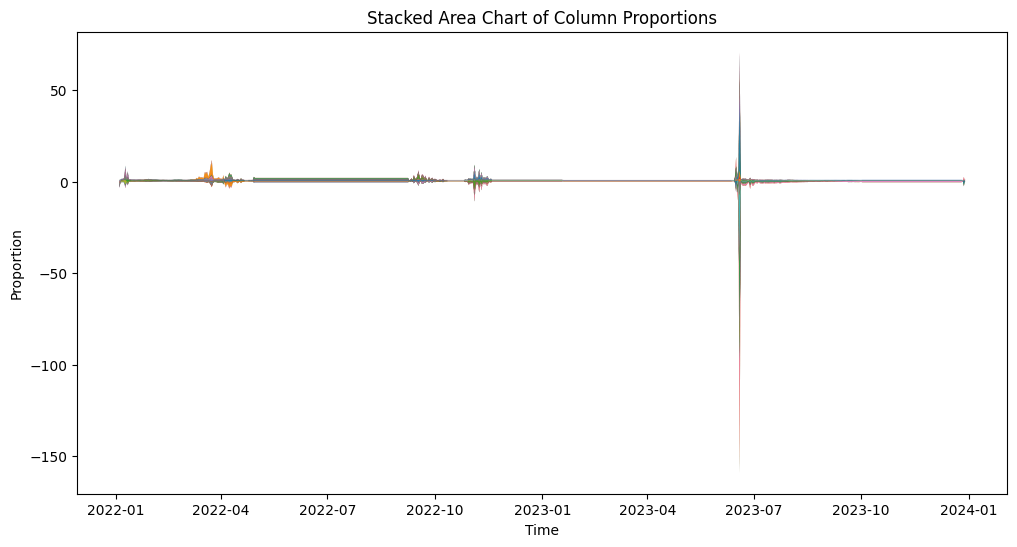

In [51]:

# Normalize to make proportions (row-wise sum = 1)
pos2 = pos2.div(pos2.sum(axis=1), axis=0)

# Define x-axis (e.g., time or index)
x = range(len(pos2))

# Plot stacked area chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.stackplot(pos2.index, pos2.T, labels=pos2.columns, alpha=0.8)

# Optional: Add legend (limited to avoid clutter)
# ax.legend(loc='upper left', fontsize='small', ncol=5, frameon=False)

# Labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Proportion")
ax.set_title("Stacked Area Chart of Column Proportions")

plt.show()

In [15]:
from datetime import date

In [22]:
pos2[pos2.index == datetime(2016, 6, 1)].T.sort_values(datetime(2016, 6, 1))

dt,2016-06-01
symbol,
A,0.000000
NRG,0.000000
NOW,0.000000
NOC,0.000000
NKE,0.000000
...,...
TSLA,0.062869
WBD,0.063513
AMZN,0.092253


<Axes: xlabel='date'>

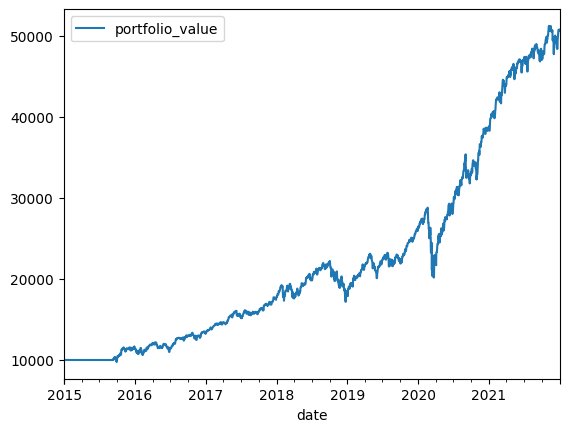

In [ ]:
port2.reset_index().plot(x='date', y='portfolio_value')

<Axes: xlabel='dt'>

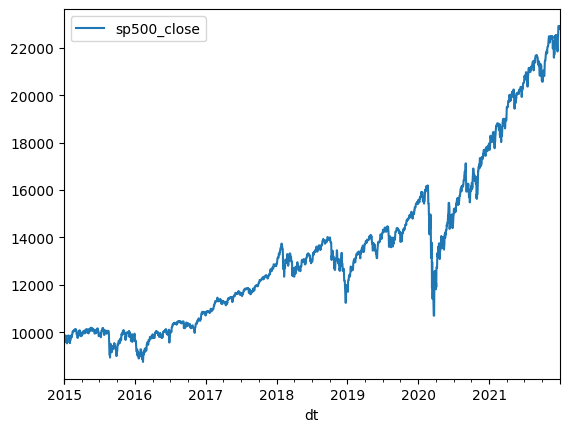

In [ ]:
t = df[['dt', 'sp500_close']].drop_duplicates('dt').copy()
t['sp500_close'] *= 10000/ t.sp500_close.iloc[0]
t.plot(x='dt', y='sp500_close')

<Axes: xlabel='date'>

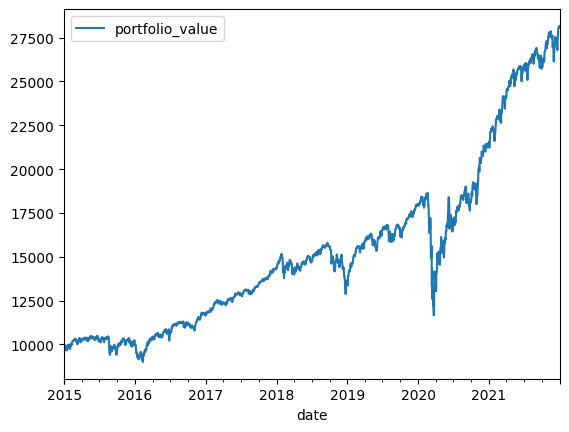

In [ ]:
port.reset_index().plot(x='date', y='portfolio_value')

In [62]:
sp = df.groupby(['dt']).agg({
    'ft_comments_90': 'mean',
    'ft_submissions_90': 'mean',
    'ft_news_90': 'mean',
    'ft_abs_comments_90': 'mean',
    'ft_abs_news_90': 'mean',
    'ft_comments_30': 'mean',
    'ft_news_30': 'mean',
    'ft_abs_comments_30': 'mean',
    'ft_abs_news_30': 'mean',
    'ft_comments_10': 'mean',
    'ft_abs_submissions_10': 'mean',
    'ft_abs_submissions_30': 'mean',
    'ft_submissions_10': 'mean',
    'ft_submissions_30': 'mean',
    'ft_news_10': 'mean',
    'ft_abs_comments_10': 'mean',
    'ft_abs_news_10': 'mean',
    'sp_tradeable_price': 'last',
    'sp_forward_returns_90': 'last',
    'sp_forward_returns_30': 'last',
    'sp_forward_returns_10': 'last',
}).reset_index()

In [63]:
for c in sp.columns:
    if c.startswith('ft_') and not c.endswith('r'):
        sp[f'{c}r'] = sp[c] - sp[c].rolling(90, min_periods=0).mean().fillna(0)

In [65]:
reduced = sp[::10]
pearsonr(reduced['ft_abs_submissions_10r'], reduced['sp_forward_returns_10'])
pearsonr(reduced['ft_submissions_10r'], reduced['sp_forward_returns_10'])
pearsonr(reduced['ft_abs_comments_10r'], reduced['sp_forward_returns_10'])

PearsonRResult(statistic=0.17101010141420456, pvalue=0.14801674250485708)

In [66]:
sp['combined'] = sp.ft_comments_10r

In [67]:
sp[sp.ft_news_10r > 0.04].sp_forward_returns_10.sum()

0.0

<Axes: xlabel='ft_abs_comments_10r', ylabel='sp_forward_returns_10'>

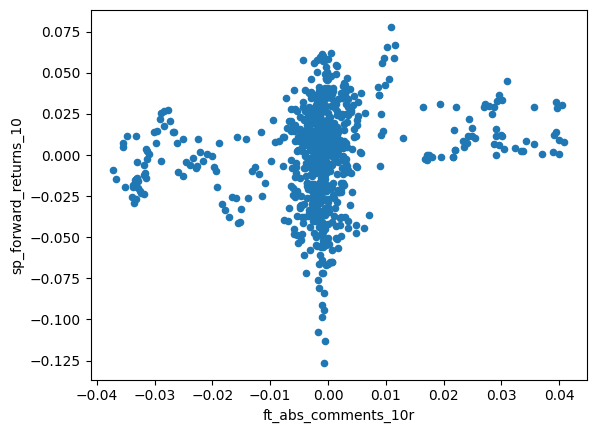

In [77]:
sp.plot(x='ft_abs_comments_10r', y='sp_forward_returns_10', kind='scatter')

In [73]:
sp['symbol'] = 'sp500'
sp['close'] = sp.sp_tradeable_price
sp['signal'] = 1
# sp['signal'] = np.where(sp.ft_abs_news_10r < 0.006, 1, -1)
# sp['signal'] = np.where(sp.ft_abs_submissions_10r + sp.ft_abs_comments_10r < 0.006, 1, -1)
sp['returns'] = np.where(sp.signal == 1, sp.sp_tradeable_price.shift(-1) / sp.sp_tradeable_price, 1)
sp['nav'] = 10000 * sp.returns.fillna(1).cumprod()


In [75]:
16*(sp.returns.fillna(1).mean() - 1) / (sp.returns.fillna(1) - 1).std()

0.07072073656663393

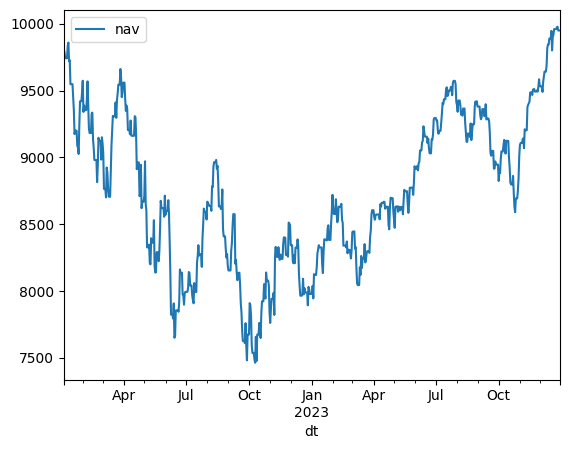

In [74]:
ax = sp.plot(x='dt', y='nav')
# sp.plot(x='dt', y='signal', ax=ax.twinx(), color='red')

,portfolio_value,cash,positions_value,transactions_cost,daily_return,cumulative_return
date,,,,,,
2014-12-29,10000.000000,10000.0,0.000000,0.0,NaN,NaN
2014-12-30,10000.000000,10000.0,0.000000,0.0,0.000000,0.000000
2014-12-31,10000.000000,10000.0,0.000000,0.0,0.000000,0.000000
2015-01-01,10000.000000,0.0,10000.000000,0.0,0.000000,0.000000
2015-01-02,9817.316101,0.0,9817.316101,0.0,-0.018268,-0.018268
...,...,...,...,...,...,...
2021-12-26,23278.592945,0.0,23278.592945,0.0,0.000000,1.327859
2021-12-27,23255.271597,0.0,23255.271597,0.0,-0.001002,1.325527
2021-12-28,23287.824313,0.0,23287.824313,0.0,0.001400,1.328782


<Axes: xlabel='date'>

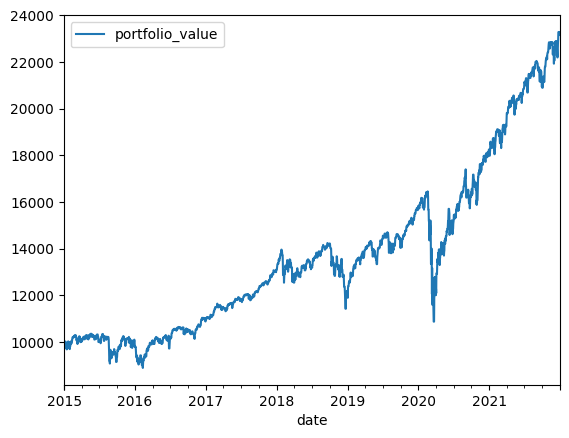

In [ ]:
port3, pos3 = simulate_portfolio_vectorized(sp, tc_rate=0)
port3.reset_index().plot(x='date', y='portfolio_value')

<Axes: xlabel='dt'>

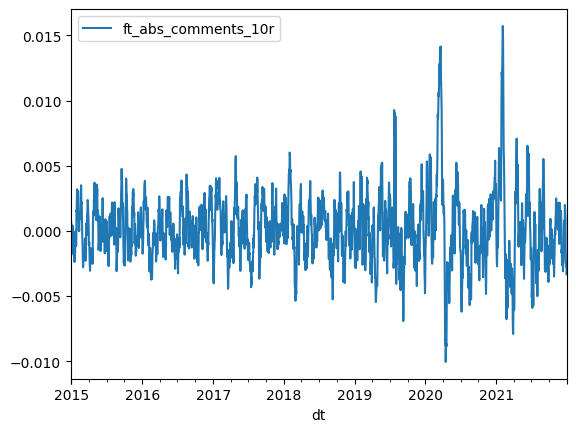

In [ ]:
sp.plot(x='dt', y='ft_abs_comments_10r')

In [ ]:
sp.signa

<Axes: xlabel='date'>

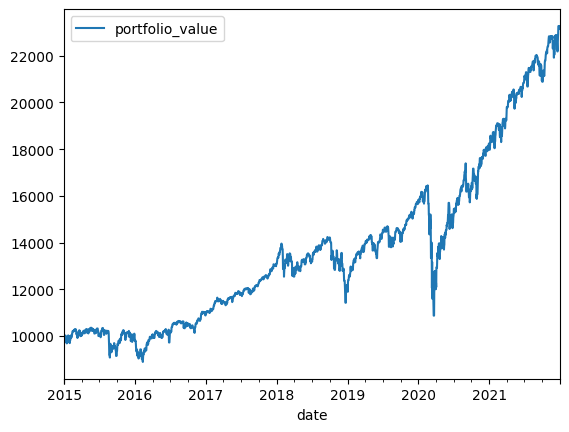

In [ ]:
sp[sp.ft_abs_comments_10r < 0.003].sp_forward_returns_10.mean()

0.004012609973506667

In [ ]:
sp['symbol'] = 

<Axes: xlabel='ft_abs_comments_10r', ylabel='sp_forward_returns_10'>

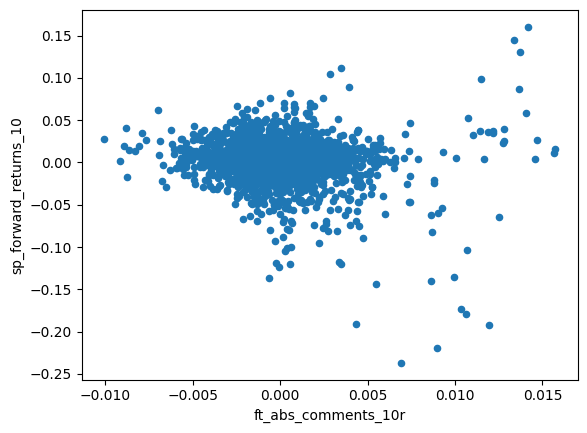

In [ ]:
sp.plot(x='ft_abs_comments_10r', y='sp_forward_returns_10', kind='scatter')

In [ ]:
sp.corr()

,dt,ft_comments_90,ft_news_90,ft_abs_comments_90,ft_abs_news_90,ft_comments_30,ft_news_30,ft_abs_comments_30,ft_abs_news_30,sp_tradeable_price,sp_forward_returns_90,sp_forward_returns_30
dt,1.000000,-0.559316,0.687606,0.953146,0.692072,-0.490748,0.691575,0.932832,0.698064,0.923112,0.218811,0.107915
ft_comments_90,-0.559316,1.000000,0.068173,-0.598836,0.057002,0.888605,0.036704,-0.588866,0.023776,-0.310217,-0.255273,-0.161192
ft_news_90,0.687606,0.068173,1.000000,0.674013,0.998570,0.086984,0.982318,0.656247,0.982304,0.847047,0.191688,0.111417
ft_abs_comments_90,0.953146,-0.598836,0.674013,1.000000,0.673496,-0.524862,0.678203,0.976476,0.679714,0.879975,0.280632,0.146488
ft_abs_news_90,0.692072,0.057002,0.998570,0.673496,1.000000,0.079269,0.981289,0.654470,0.984224,0.855408,0.192502,0.112396
ft_comments_30,-0.490748,0.888605,0.086984,-0.524862,0.079269,1.000000,0.084403,-0.541931,0.068332,-0.243747,-0.305798,-0.157715
ft_news_30,0.691575,0.036704,0.982318,0.678203,0.981289,0.084403,1.000000,0.657599,0.997672,0.831037,0.217012,0.127507
ft_abs_comments_30,0.932832,-0.588866,0.656247,0.976476,0.654470,-0.541931,0.657599,1.000000,0.656965,0.843275,0.297394,0.161202
ft_abs_news_30,0.698064,0.023776,0.982304,0.679714,0.984224,0.068332,0.997672,0.656965,1.000000,0.843321,0.217186,0.124888
sp_tradeable_price,0.923112,-0.310217,0.847047,0.879975,0.855408,-0.243747,0.831037,0.843275,0.843321,1.000000,0.081947,0.020058
